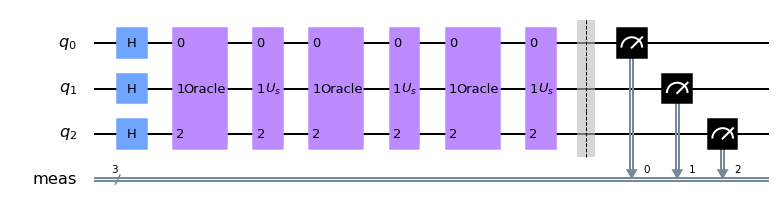

In [57]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator

# import basic plot tools
from qiskit.visualization import plot_histogram

# functions
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s    

#Oracle
oracle = Operator([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, -1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, -1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, -1]
])

# main
n = 3
qbits = [0,1,2]
iterations = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, qbits)
for i in range(iterations):
    grover_circuit.unitary(oracle, qbits, label='Oracle')
    grover_circuit.append(diffuser(n), qbits)

grover_circuit.measure_all()
grover_circuit.draw()

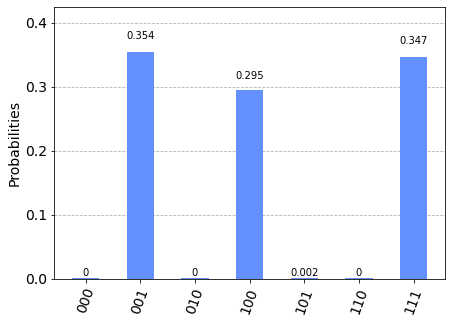

In [58]:

qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)